<a href="https://colab.research.google.com/github/marcoBmota8/DLCausalOptimization/blob/main/TabNet_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install pytorch-tabnet
!git clone https://github.com/capitalone/synthetic-data.git
!apt install python3.10-venv
!pip install pandas pytest pytest-cov seaborn shap tensorflow "DataProfiler[full]"

In [2]:
!cd /content/synthetic-data
!python3 -m venv .venv
!source .venv/bin/activate
!pip install -r /content/synthetic-data/requirements.txt
!pip install -e /content/synthetic-data

Obtaining file:///content/synthetic-data
  Preparing metadata (setup.py) ... done
  Attempting uninstall: synthetic-data
    Found existing installation: synthetic-data 1.2.3
    Uninstalling synthetic-data-1.2.3:
      Successfully uninstalled synthetic-data-1.2.3
  Running setup.py develop for synthetic-data


In [120]:
import os

import torch
import pytorch_tabnet
import dataprofiler as dp
import numpy as np
import pandas as pd

os.chdir('/content/synthetic-data')

from synthetic_data import Generator
from synthetic_data.distinct_generators import datetime_generator
from synthetic_data.generators import TabularGenerator
from synthetic_data.synthetic_data import make_tabular_data

from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt


dp.set_seed(0)

profile_options = dp.ProfilerOptions()
profile_options.set(
    {
        "data_labeler.is_enabled": False,
        "correlation.is_enabled": True,
        "multiprocess.is_enabled": False,
    }
)

tab_data = dp.Data(os.path.join(os.getcwd(), "tests/data/iris.csv"))
tab_profile = dp.Profiler(
    tab_data, profiler_type="structured", options=profile_options
)
generator = Generator(profile=tab_profile, seed=42)
synthetic_data = generator.synthesize(250)

# col_map = {"x1": 0, "x2": 1, "x3": 2, "x4": 3}

# synthetic_data = make_tabular_data(n_samples=100, n_informative=4, col_map=col_map)
print(synthetic_data)

# print("hi")

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns... 


INFO:DataProfiler.profilers.profile_builder:Finding the Null values in the columns... 
100%|██████████| 5/5 [00:00<00:00, 153.50it/s]

INFO:DataProfiler.profilers.profile_builder: Calculating the statistics... 



INFO:DataProfiler.profilers.profile_builder:Calculating the statistics... 
100%|██████████| 5/5 [00:00<00:00,  5.02it/s]


sepal length (cm) True
0 float
sepal width (cm) True
1 float
petal length (cm) True
2 float
petal width (cm) True
3 float
target False
4 int
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.4               3.1                3.0              0.49   
1                  5.5               2.3                4.7              1.39   
2                  6.7               2.9                4.8              1.85   
3                  6.9               3.1                4.9              1.87   
4                  4.9               3.2                1.1              0.18   
..                 ...               ...                ...               ...   
245                5.7               3.1                4.6              1.23   
246                6.6               3.6                5.2              1.88   
247                4.3               2.9                1.1              0.14   
248                6.3               3.0         

In [121]:
train = synthetic_data
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
print(train)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.4               3.1                3.0              0.49   
1                  5.5               2.3                4.7              1.39   
2                  6.7               2.9                4.8              1.85   
3                  6.9               3.1                4.9              1.87   
4                  4.9               3.2                1.1              0.18   
..                 ...               ...                ...               ...   
245                5.7               3.1                4.6              1.23   
246                6.6               3.6                5.2              1.88   
247                4.3               2.9                1.1              0.14   
248                6.3               3.0                4.7              1.79   
249                6.7               2.9                5.9              2.37   

     target    Set  
0     

In [122]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)
    print(col)

print(train)
print(categorical_columns)
print(categorical_dims)

Set 3
sepal length (cm)
sepal width (cm)
petal length (cm)
petal width (cm)
target
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.4               3.1                3.0              0.49   
1                  5.5               2.3                4.7              1.39   
2                  6.7               2.9                4.8              1.85   
3                  6.9               3.1                4.9              1.87   
4                  4.9               3.2                1.1              0.18   
..                 ...               ...                ...               ...   
245                5.7               3.1                4.6              1.23   
246                6.6               3.6                5.2              1.88   
247                4.3               2.9                1.1              0.14   
248                6.3               3.0                4.7              1.79   
249                6.7    

In [123]:
unused_feat = ['Set']
target = "target"

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

cat_emb_dim = []

print(features)
print(cat_idxs)
print(cat_dims)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[]
[]


In [181]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs, optimizer_fn=torch.optim.SGD, optimizer_params=dict(lr=5e-2))

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [183]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

max_epochs = 250
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [184]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    augmentations=aug,
)

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)
dataset_name = "iris"

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

epoch 0  | loss: 2.4157  | train_rmsle: 1.5483  | train_mae: 10.73273| train_rmse: 13.29407| train_mse: 176.73242| valid_rmsle: 1.61919 | valid_mae: 10.93686| valid_rmse: 13.70436| valid_mse: 187.80961|  0:00:00s
epoch 1  | loss: 1.9852  | train_rmsle: 1.46984 | train_mae: 9.15016 | train_rmse: 11.94048| train_mse: 142.57512| valid_rmsle: 1.40363 | valid_mae: 8.26012 | valid_rmse: 11.4387 | valid_mse: 130.84392|  0:00:00s
epoch 2  | loss: 1.87897 | train_rmsle: 1.50967 | train_mae: 8.70589 | train_rmse: 11.62412| train_mse: 135.12018| valid_rmsle: 1.56495 | valid_mae: 9.16898 | valid_rmse: 12.12232| valid_mse: 146.95071|  0:00:00s
epoch 3  | loss: 1.53767 | train_rmsle: 1.72419 | train_mae: 9.759   | train_rmse: 12.25019| train_mse: 150.06725| valid_rmsle: 1.59293 | valid_mae: 9.18977 | valid_rmse: 12.05926| valid_mse: 145.42565|  0:00:00s
epoch 4  | loss: 1.42632 | train_rmsle: 1.75719 | train_mae: 9.69268 | train_rmse: 12.1959 | train_mse: 148.73995| valid_rmsle: 1.64764 | valid_mae:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [189]:
saving_path_name = "/content/tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL MSE TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

rounded_preds = loaded_preds
for i in range(0, len(rounded_preds)):
  rounded_preds[i][0] = round(loaded_preds[i][0])
# print(rounded_preds)
accuracy = (rounded_preds == y_test).sum() / len(y_test)
acc_percent = round(accuracy*100, 2)
print(f"Testing accuracy for {dataset_name}: {acc_percent}%")

Successfully saved model at /content/tabnet_model_test_1.zip
FINAL MSE TEST SCORE FOR iris : 0.15312814536405625
Testing accuracy for iris: 76.92%


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


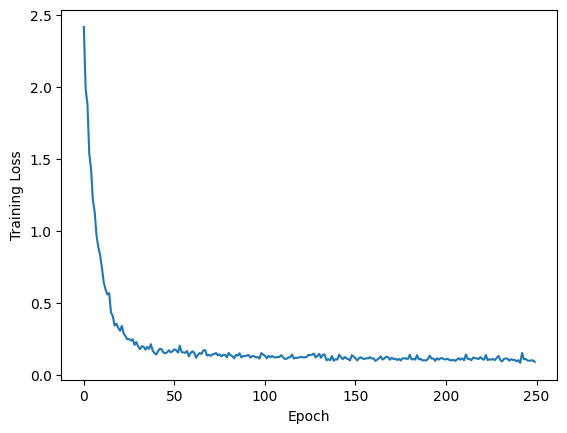

In [190]:
loss_history = clf.history['loss']
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(loss_history)

[0.19851833 0.16362336 0.40321816 0.23464015]


<BarContainer object of 4 artists>

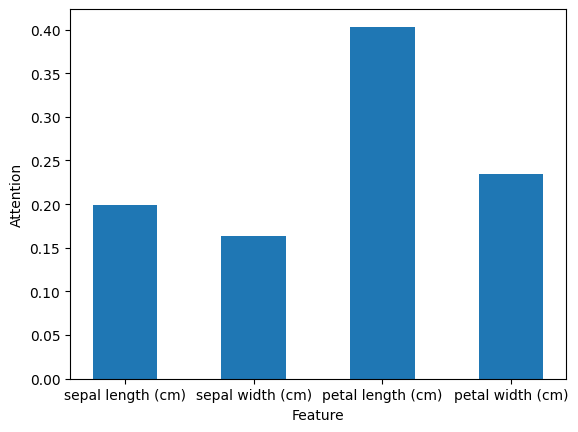

In [191]:
feature_attention = clf.feature_importances_
print(feature_attention)
plt.xlabel("Feature")
plt.ylabel("Attention")
plt.bar(features, feature_attention, width = 0.5)

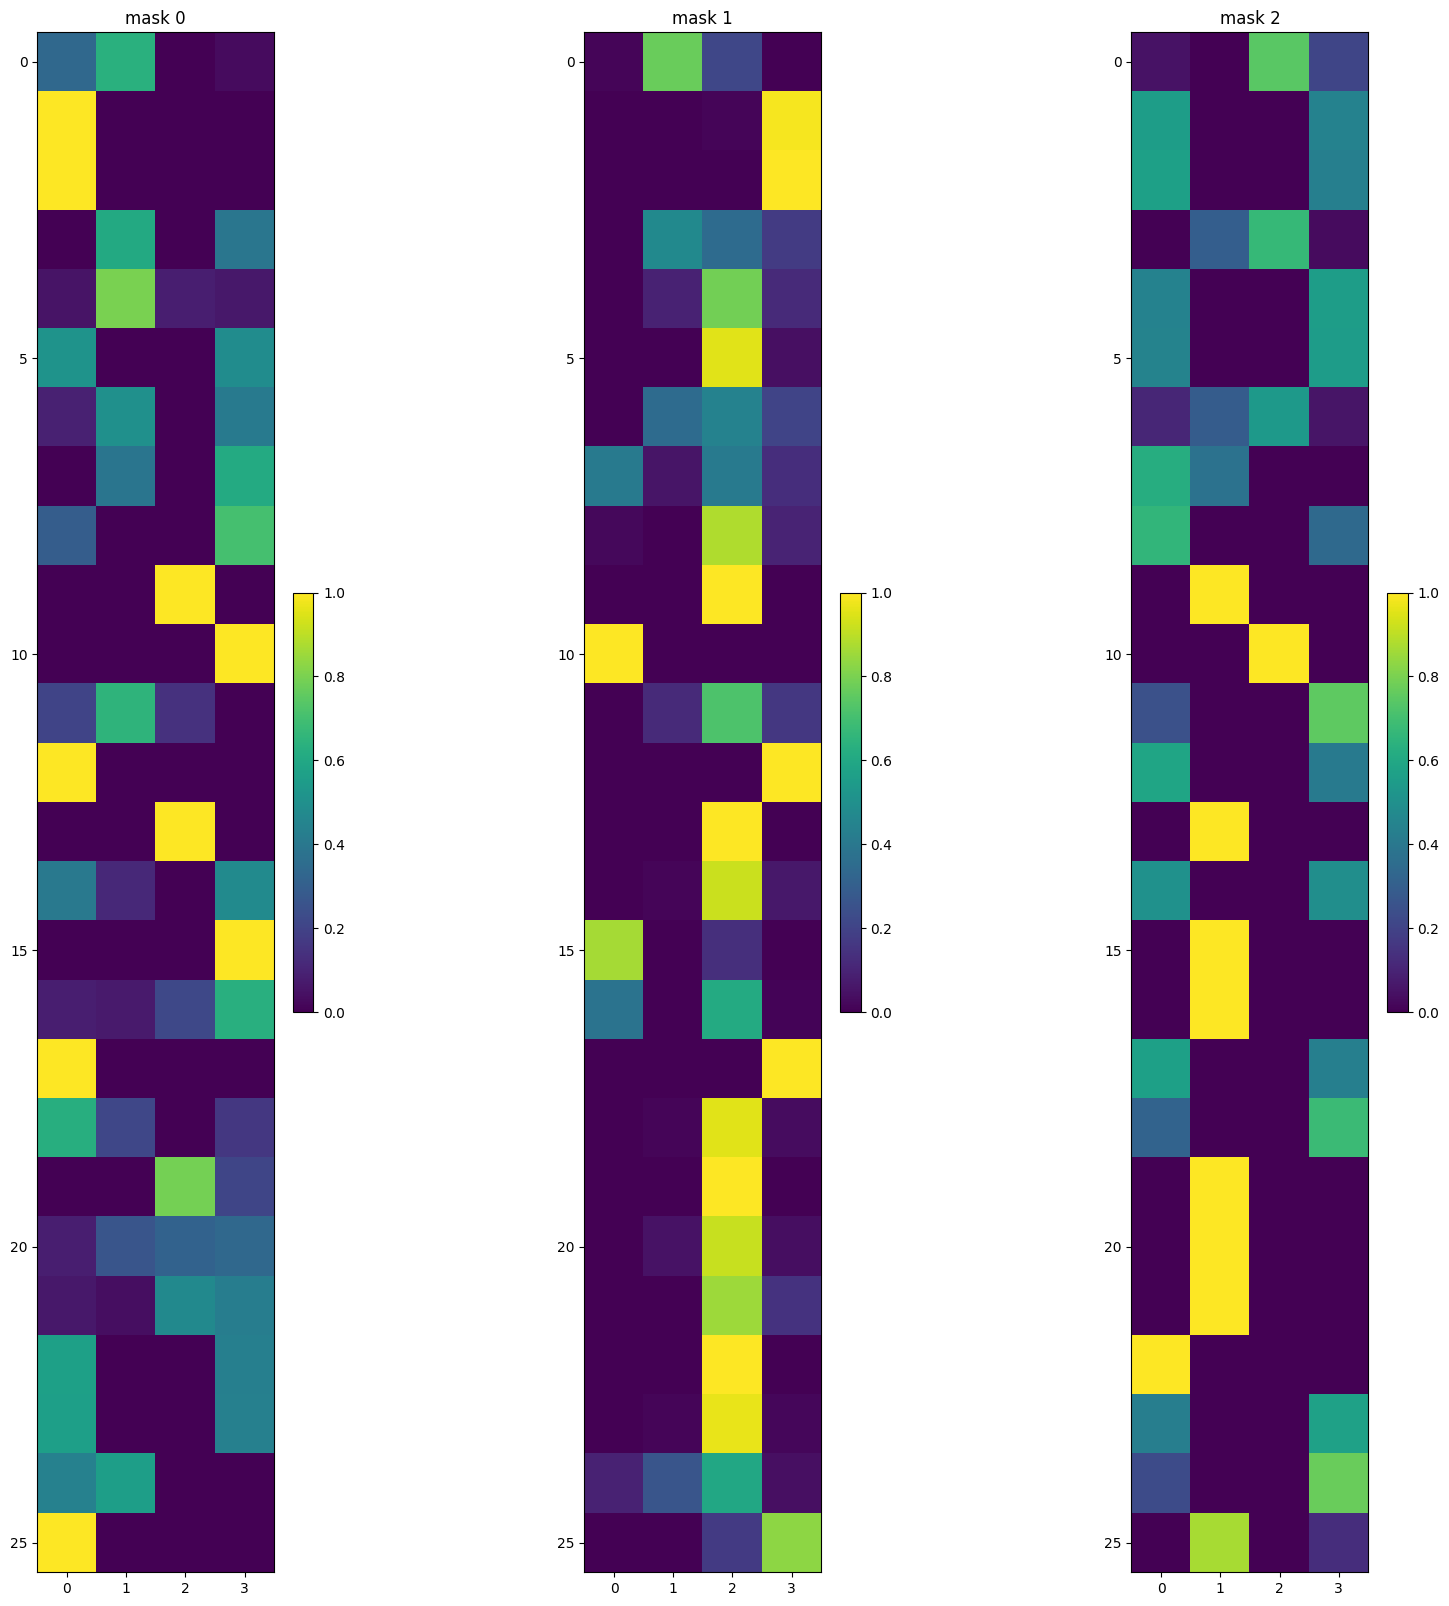

In [287]:
explain_matrix, masks = clf.explain(X_test)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    im = axs[i].imshow(masks[i][:50])
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_title(f"mask {i}")

# Above is based on the regression_example.ipynb
# Below directly trains and implements a network
# Both use synthesized iris dataset

In [289]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)
X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [350]:
import torch.nn as nn
import torch.optim as optim
from pytorch_tabnet.tab_network import TabNetNoEmbeddings

test_model = TabNetNoEmbeddings(input_dim=4, output_dim=1)

def model_train(model, n_epochs):
    criterion = nn.MSELoss()
    learning_rate = 0.01
    optimizer = optim.SGD(model.parameters(), lr = learning_rate)

    model.train()
    mse_values = []
    input = torch.FloatTensor(X_train)
    y = torch.FloatTensor(y_train)
    masks = []

    # Train the model
    for i in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(input)
        # masks.append(model.forward_masks(input)[0])
        loss = criterion(outputs[0], y)
        loss.backward()
        optimizer.step()

        mse_values.append(loss.item())

    train_masks = model.forward_masks(input)

    model.eval()
    with torch.no_grad():
        test_output = model(torch.FloatTensor(X_test))
        test_masks = model.forward_masks(torch.FloatTensor(X_test))
        pred_y = torch.round(test_output[0])
        accuracy = (pred_y == torch.FloatTensor(y_test)).sum().item() / float(pred_y.size(0))

    return mse_values, accuracy, train_masks, test_masks


n_epochs = 250
test_train, test_acc, train_masks, test_masks = model_train(test_model, n_epochs)

print("Test accuracy:", test_acc)
print("Minimum MSE:", min(test_train))


Test accuracy: 0.8076923076923077
Minimum MSE: 0.11148720234632492


### Training loss graph

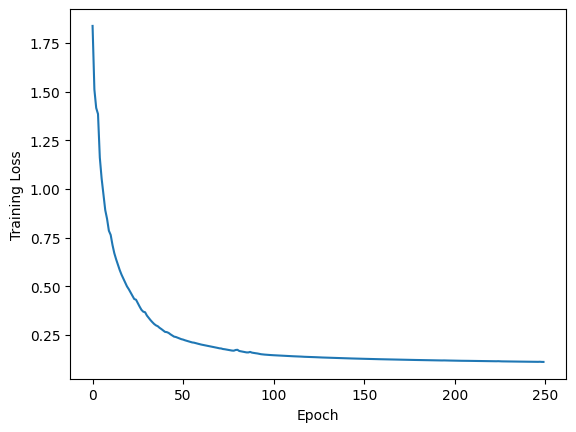

In [354]:
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(range(n_epochs), test_train)

### Training feature attention graph

Feature attention: [0.23404483 0.28605226 0.24183282 0.23807001]


<BarContainer object of 4 artists>

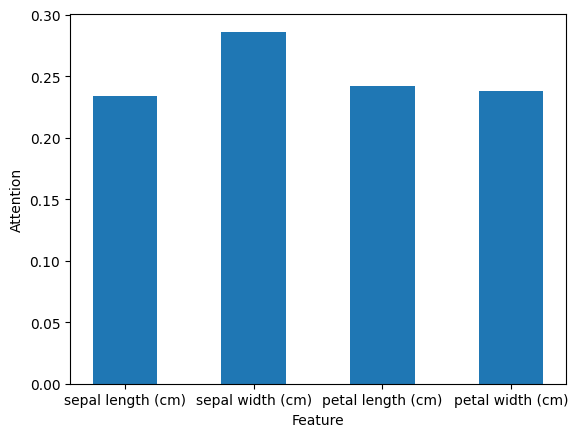

In [355]:
feature_importance = np.sum(train_masks[0].detach().numpy(), axis=0)
sum = np.sum(feature_importance)
feature_attention = feature_importance / sum
print("Feature attention:", feature_attention)
plt.xlabel("Feature")
plt.ylabel("Attention")
plt.bar(features, feature_attention, width = 0.5)

### Test feature importance mask graphs

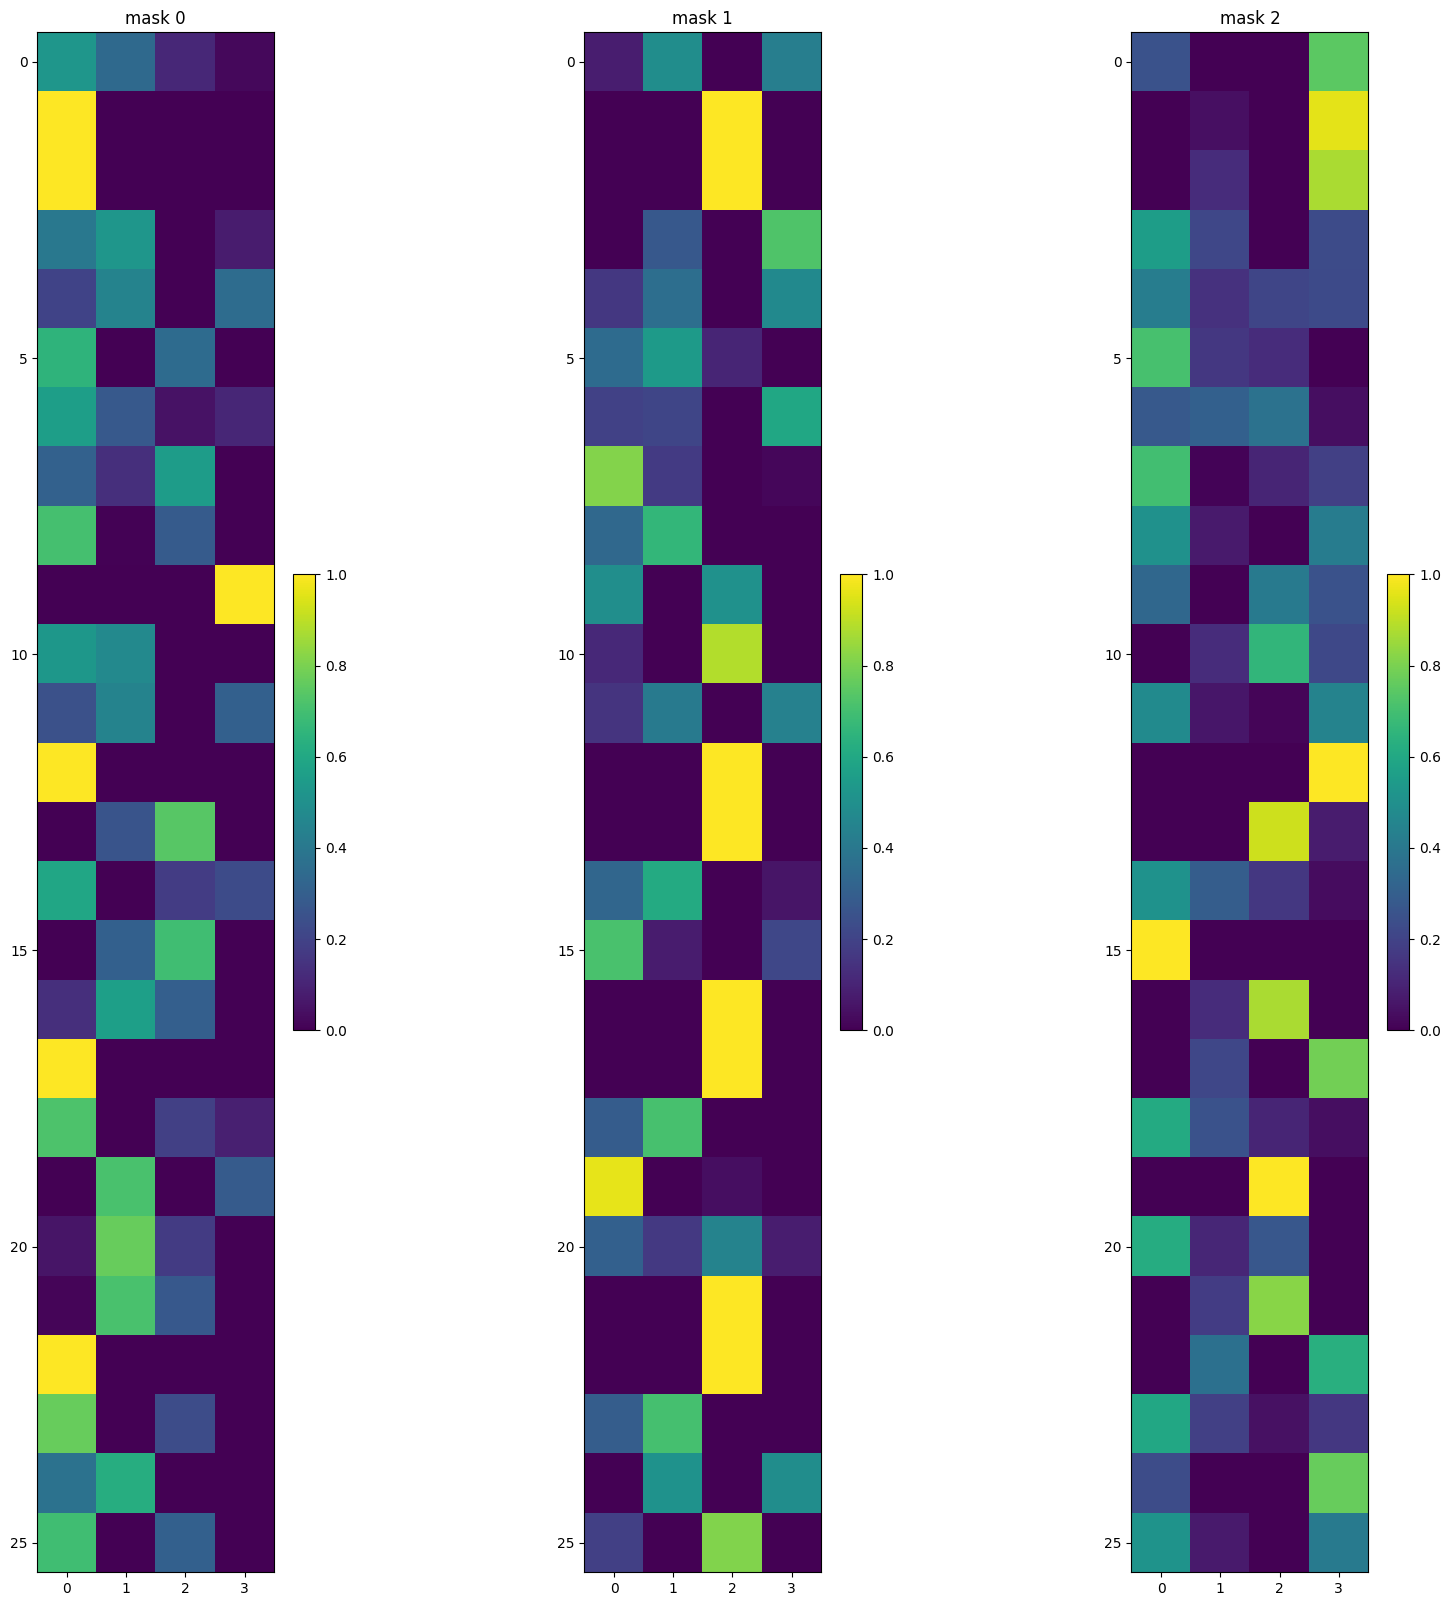

In [356]:
masks_list = []
for i in range(len(test_masks[1])):
  masks_list.append(test_masks[1][i].detach().numpy())
# print(masks_list)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    im = axs[i].imshow(masks_list[i])
    fig.colorbar(im, ax=axs[i], fraction=0.05, pad=0.04)
    axs[i].set_title(f"mask {i}")